# Softmax Regression Example

### 生成数据集， 看明白即可无需填写代码
#### '<font color="blue">+</font>' 从高斯分布采样 (X, Y) ~ N(3, 6, 1, 1, 0).<br>
#### '<font color="green">o</font>' 从高斯分布采样  (X, Y) ~ N(6, 3, 1, 1, 0)<br>
#### '<font color="red">*</font>' 从高斯分布采样  (X, Y) ~ N(7, 7, 1, 1, 0)<br>

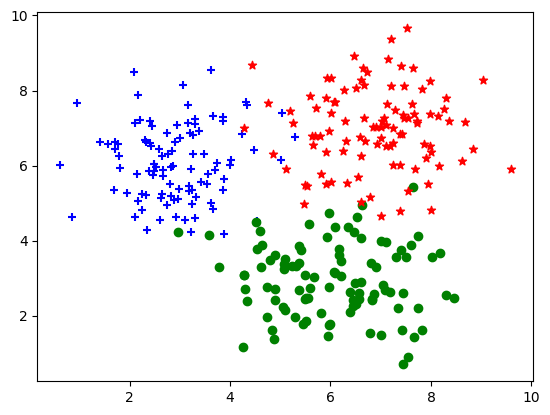

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.cm as cm
import numpy as np
%matplotlib inline

dot_num = 100
x_p = np.random.normal(3., 1, dot_num)
y_p = np.random.normal(6., 1, dot_num)
y = np.ones(dot_num)
C1 = np.array([x_p, y_p, y]).T

x_n = np.random.normal(6., 1, dot_num)
y_n = np.random.normal(3., 1, dot_num)
y = np.zeros(dot_num)
C2 = np.array([x_n, y_n, y]).T

x_b = np.random.normal(7., 1, dot_num)
y_b = np.random.normal(7., 1, dot_num)
y = np.ones(dot_num)*2
C3 = np.array([x_b, y_b, y]).T

plt.scatter(C1[:, 0], C1[:, 1], c='b', marker='+')
plt.scatter(C2[:, 0], C2[:, 1], c='g', marker='o')
plt.scatter(C3[:, 0], C3[:, 1], c='r', marker='*')

data_set = np.concatenate((C1, C2, C3), axis=0)
np.random.shuffle(data_set)


## 建立模型
建立模型类，定义loss函数，定义一步梯度下降过程函数

填空一：在`__init__`构造函数中建立模型所需的参数

填空二：实现softmax的交叉熵损失函数(不使用tf内置的loss 函数)

In [2]:
# 定义一个很小的常数，用于数值稳定性，防止log(0)的情况
epsilon = 1e-12

class SoftmaxRegression():
    """Softmax回归模型类，用于多分类问题"""
    def __init__(self):
        '''============================='''
        # todo 填空一，构建模型所需的参数 self.W, self.b 可以参考logistic-regression-exercise
        
        # 初始化权重矩阵W，形状为[2, 3]
        # 2表示输入特征数，3表示输出类别数（三分类问题）
        # 使用小的随机值初始化，范围在[-0.1, 0.1]之间
        self.W = tf.Variable(shape=[2, 3], dtype=tf.float32, 
            initial_value=tf.random.uniform(shape=[2, 3], minval=-0.1, maxval=0.1))
        
        # 初始化偏置项b，形状为[3]，对应3个类别，初始值为0
        #[z₁, z₂, z₃] = [x₁, x₂] · W + [b₁, b₂, b₃]
        self.b = tf.Variable(shape=[3], dtype=tf.float32, initial_value=tf.zeros(shape=[3]))
        '''============================='''
        
        # 将需要训练的参数放入列表，方便优化器使用
        self.trainable_variables = [self.W, self.b]
    
    @tf.function  # 装饰器，将函数编译为TensorFlow图，提高执行效率
    def __call__(self, inp):
        """
        前向传播函数
        inp: 输入数据，形状为(N, 2)，N是样本数量，2是特征数
        返回: 预测概率分布，形状为(N, 3)，每行是一个样本对3个类别的概率
        """
        # 计算线性组合：Z = X*W + b
        logits = tf.matmul(inp, self.W) + self.b  # shape(N, 3)
        # 通过softmax函数将logits转换为概率分布
        # softmax确保每行概率和为1，且每个概率都在[0,1]之间
        pred = tf.nn.softmax(logits)
        return pred    
    
@tf.function
def compute_loss(pred, label):
    """
    计算损失函数和准确率
    pred: 模型预测概率分布，形状为(N, 3)
    label: 真实标签，形状为(N,)，包含类别索引(0, 1, 2)
    返回: (损失值, 准确率)
    """
    # 将标签转换为one-hot编码
    # 例如：标签1 -> [0, 1, 0]，标签2 -> [0, 0, 1]
    label = tf.one_hot(tf.cast(label, dtype=tf.int32), dtype=tf.float32, depth=3)
    
    '''============================='''
    # 输入label shape(N, 3), pred shape(N, 3)
    # 输出 losses shape(N,) 每一个样本一个loss
    # todo 填空二，实现softmax的交叉熵损失函数(不使用tf内置的loss函数)
    
    # 为了数值稳定性，将预测值限制在 [epsilon, 1-epsilon] 范围内
    # 防止log(0)导致的数值问题
    pred = tf.clip_by_value(pred, epsilon, 1 - epsilon)
    
    # 计算多分类交叉熵损失：-∑(y_i * log(p_i))
    # 对于每个样本，只有真实类别对应的项不为0
    # 例如：真实标签为[0,1,0]，预测为[0.2,0.7,0.1]
    # 损失为：-(0*log(0.2) + 1*log(0.7) + 0*log(0.1)) = -log(0.7)
    losses = -tf.reduce_sum(label * tf.math.log(pred), axis=1)  # shape(N,)
    '''============================='''
    
    # 计算所有样本的平均损失
    loss = tf.reduce_mean(losses)
    
    # 计算准确率：比较预测类别和真实类别
    # tf.argmax找到概率最大的类别索引
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(label, axis=1), tf.argmax(pred, axis=1)), dtype=tf.float32))
    return loss, accuracy

@tf.function
def train_one_step(model, optimizer, x, y):
    """
    执行一步训练
    model: Softmax回归模型
    optimizer: 优化器（如Adam、SGD等）
    x: 输入特征，形状为(N, 2)
    y: 真实标签，形状为(N,)，包含类别索引
    返回: (损失值, 准确率)
    """
    # 使用GradientTape记录前向传播过程，用于自动求导
    with tf.GradientTape() as tape:
        # 前向传播：计算预测概率分布
        pred = model(x)
        # 计算损失和准确率
        loss, accuracy = compute_loss(pred, y)
        
    # 反向传播：计算损失对模型参数的梯度
    grads = tape.gradient(loss, model.trainable_variables)
    
    # 使用优化器更新模型参数
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # 返回当前步的训练结果
    return loss, accuracy

### 实例化一个模型，进行训练

In [5]:
model = SoftmaxRegression()
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
x1, x2, y = list(zip(*data_set))
x = tf.constant(list(zip(x1, x2)), dtype=tf.float32)
for i in range(1000):
    loss, accuracy = train_one_step(model, opt, x, y)
    if i%50==49:
        print(f'loss: {loss.numpy():.4}\t accuracy: {accuracy.numpy():.4}')

loss: 0.735	 accuracy: 0.8367
loss: 0.6123	 accuracy: 0.8633
loss: 0.5427	 accuracy: 0.8867
loss: 0.4968	 accuracy: 0.89
loss: 0.4635	 accuracy: 0.8967
loss: 0.4381	 accuracy: 0.9033
loss: 0.418	 accuracy: 0.9033
loss: 0.4014	 accuracy: 0.9067
loss: 0.3876	 accuracy: 0.9067
loss: 0.3758	 accuracy: 0.9067
loss: 0.3656	 accuracy: 0.91
loss: 0.3567	 accuracy: 0.9133
loss: 0.3488	 accuracy: 0.9167
loss: 0.3418	 accuracy: 0.9167
loss: 0.3354	 accuracy: 0.9167
loss: 0.3297	 accuracy: 0.9167
loss: 0.3245	 accuracy: 0.9167
loss: 0.3197	 accuracy: 0.9167
loss: 0.3153	 accuracy: 0.9167
loss: 0.3113	 accuracy: 0.9167


## 结果展示，无需填写代码

(10000, 2)


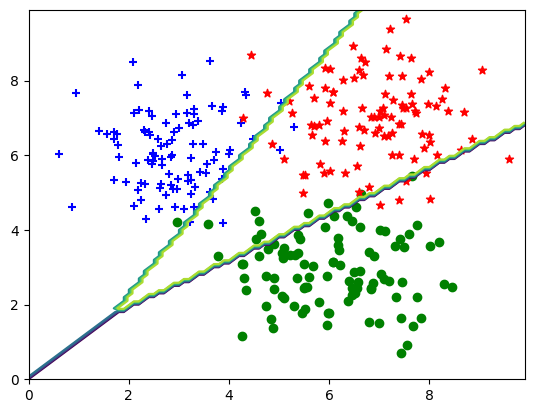

In [6]:
plt.scatter(C1[:, 0], C1[:, 1], c='b', marker='+')
plt.scatter(C2[:, 0], C2[:, 1], c='g', marker='o')
plt.scatter(C3[:, 0], C3[:, 1], c='r', marker='*')

x = np.arange(0., 10., 0.1)
y = np.arange(0., 10., 0.1)

X, Y = np.meshgrid(x, y)
inp = np.array(list(zip(X.reshape(-1), Y.reshape(-1))), dtype=np.float32)
print(inp.shape)
Z = model(inp)
Z = np.argmax(Z, axis=1)
Z = Z.reshape(X.shape)
plt.contour(X,Y,Z)
plt.show()